In [1]:
import sys
sys.path.append('../src')

In [2]:
from metrics import calculate_false_alarm, calculate_delay, calculate_precision, compute_metrics
from loading import *
from visualization import *
from features import *
from helpers import *

from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter, firwin, spectrogram, freqz, freqs

In [3]:
%matplotlib inline

# Experiement different filtering methods

In [4]:
data_path = "../data/"
patient_data = load_patient_seizures(data_path, 2,all_seizures=True, delta=1)

Seizure starts (s):  [[824604.12214844]
 [837451.78589844]]
Seizure ends (s):  [[824690.37769531]
 [837541.65542969]]
Duration (s):  [[86.25554687]
 [89.86953125]]
Sampled frequency (Hz):  512
Start/end [824604.12214844] [824690.37769531]
Start/end [837451.78589844] [837541.65542969]
EEG files:  [['../data/ID02/ID02_229h.mat', '../data/ID02/ID02_230h.mat', '../data/ID02/ID02_231h.mat'], ['../data/ID02/ID02_232h.mat', '../data/ID02/ID02_233h.mat', '../data/ID02/ID02_234h.mat']]
Hour of seizure:  [array([229, 230, 231]), array([232, 233, 234])]
Samples ranges:  [(104510, 148673), (1152914, 1198927)]


In [5]:
eegs = patient_data['eegs']
ranges = patient_data['ranges']
seizure_start_s = patient_data["infos"]["seizure_start"]
seizure_end_s = patient_data["infos"]["seizure_end"] 

In [6]:
max_power_eeg = top_signals(eegs, ranges, top=1, id_seizure = None)

In [7]:
seizure1_signal = eegs[0][1][max_power_eeg].T

In [8]:
normal1_signal = eegs[0][0][max_power_eeg].T

# Filtering functions

## Butterwoth filter

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=True)
    return b, a

In [10]:
def calculate_butter_filtered_signal(signal, f_min, f_max, fs):
    b, a = butter_bandpass(f_min, f_max, fs, order=3)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

## Butter bandpass frequency response

In [11]:
def plot_butter_frequency_response(f_min, f_max):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 512.0

    # Plot the frequency response for a few different orders.
    plt.figure(figsize=(20,10))
    for order in [3, 6, 9]:
        b, a = butter_bandpass(f_min, f_max, fs, order=order)
        w, h = freqs(b, a)
        plt.plot(w, 20 * np.log10(abs(h)), label="order = %d" % order)

    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')
    plt.legend(loc='best')

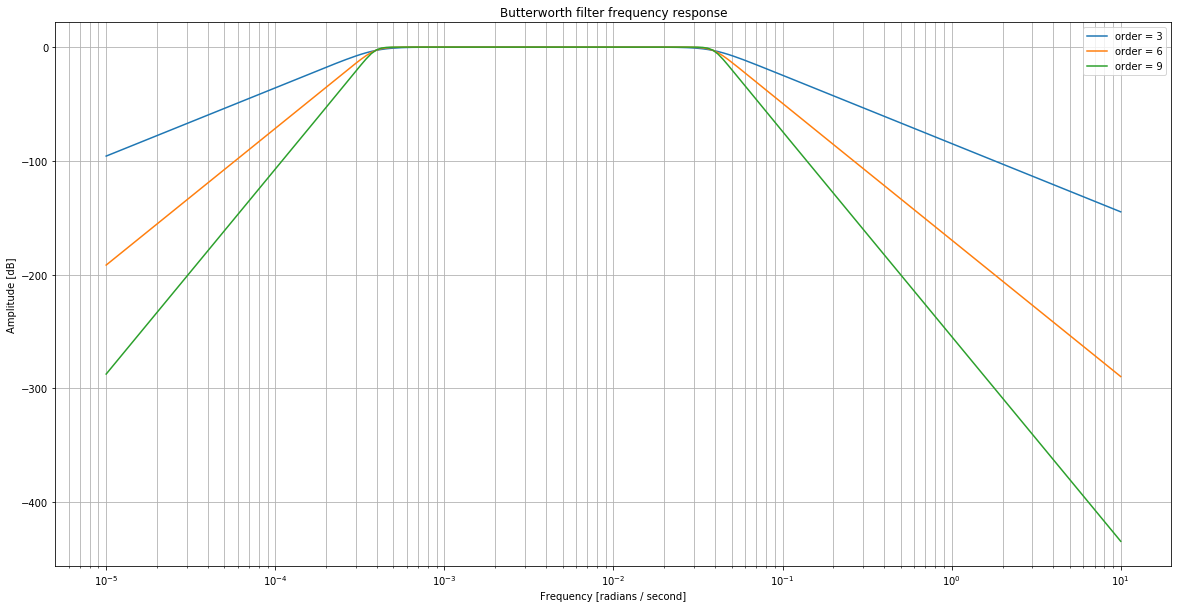

In [12]:
plot_butter_frequency_response(0.1, 10)

## FIR filter

In [13]:
def calculate_fir_filtered_signal(signal, f_min, f_max, fs, order=15):
    taps = firwin(order, [f_min, f_max], pass_zero=False, nyq=0.5*fs)
    filtered_signal = lfilter(taps, 1.0, signal)
    return filtered_signal

## FIR bandpass frequency response

In [14]:
def plot_fir_fequency_response(f_min, f_max):
        # Sample rate and desired cutoff frequencies (in Hz).
    fs = 512.0

    # Plot the frequency response for a few different orders.
    plt.figure(figsize=(20,10))
    for order in [6, 9, 15]:
        taps = firwin(order, [f_min, f_max], pass_zero=False, nyq=0.5*fs)
        w, h = freqz(taps, 1, worN=100)
        plt.plot(w, 20 * np.log10(abs(h)), label="order = %d" % order)

    plt.xscale('log')
    plt.title('FIR filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')
    plt.legend(loc='best')
    

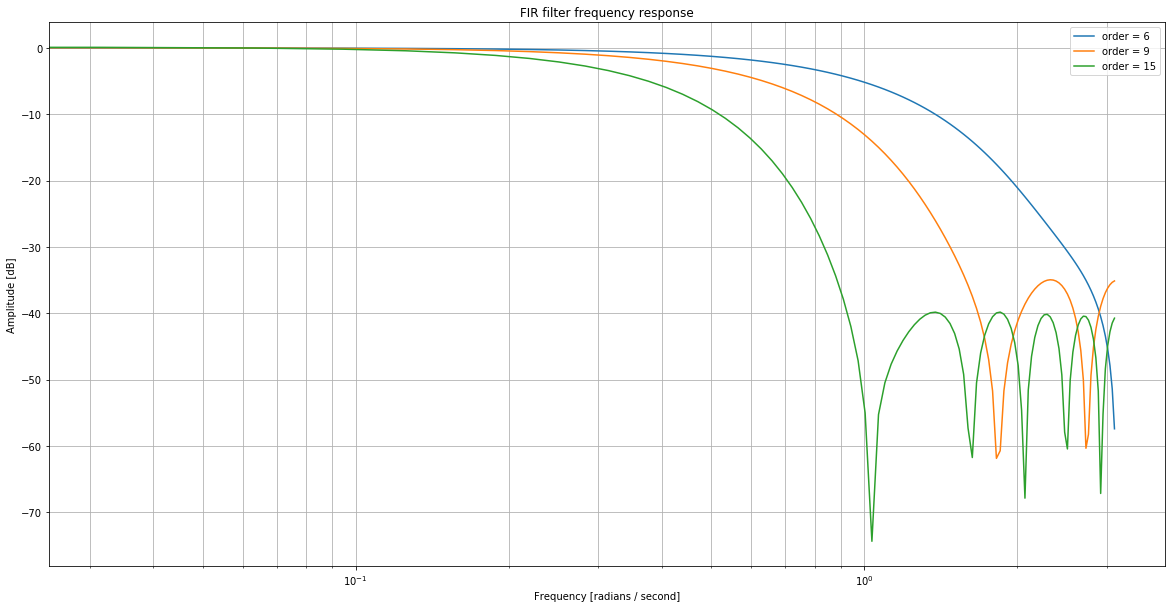

In [15]:
plot_fir_fequency_response(0.1, 10)

## Test on iEEG signal

In [16]:
def plot_filtered_signal(signal, filtered_signal, scale=False):
    scale_factor = 0
    if scale:
        scale_factor = int((np.max(signal)/np.max(filtered_signal))/2)
        print("Signal was scaled with scale_factor: ", scale_factor)
    else:
        scale_factor = 1
    
    plt.figure(figsize=(20,10))
    plt.plot(signal[195000:200000])
    plt.plot(filtered_signal[195000:200000]*scale_factor)
    plt.show()

In [17]:
seizure1_signal_filtered_butter =  calculate_butter_filtered_signal(seizure1_signal, 128, 256, 512.0)

In [18]:
seizure1_signal_filtered_fir =  calculate_fir_filtered_signal(seizure1_signal, 0.1, 4, 512.0)

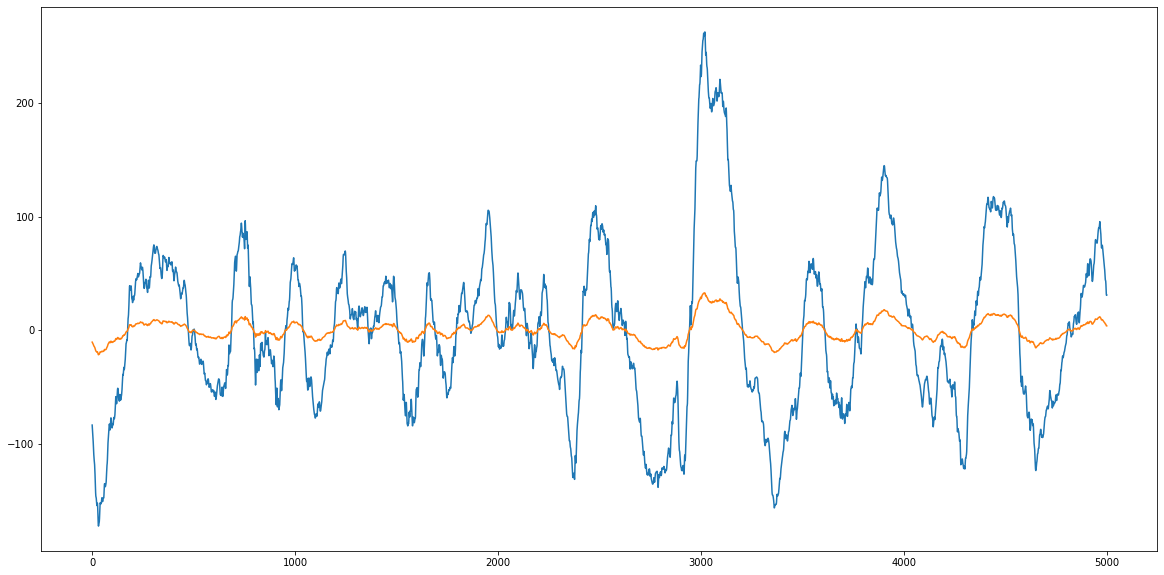

In [19]:
plot_filtered_signal(seizure1_signal, seizure1_signal_filtered_butter, scale=False)

Signal was scaled with scale_factor:  48


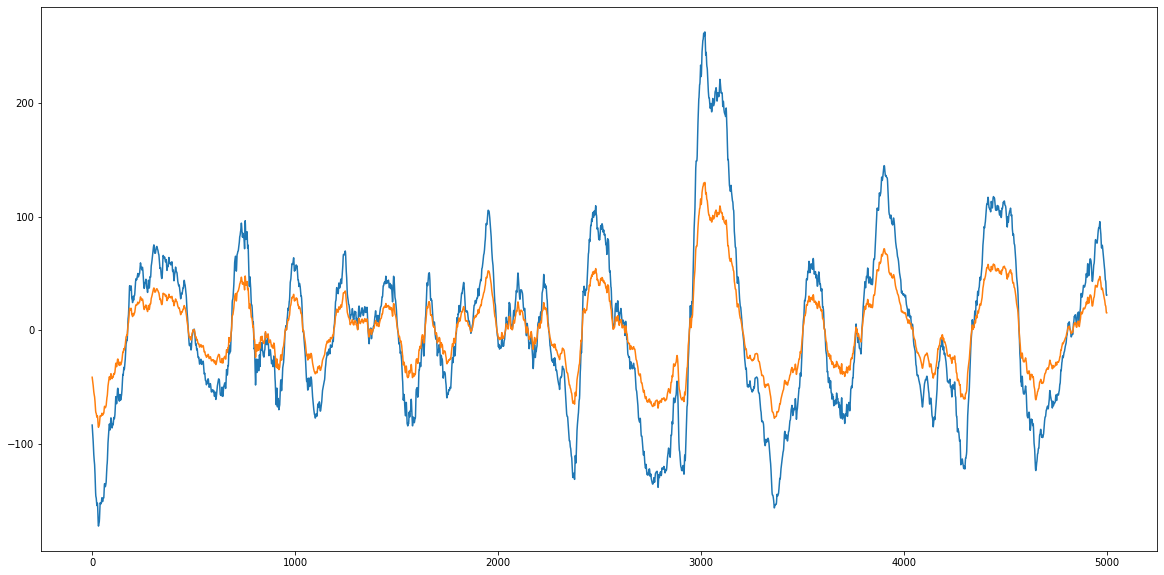

In [20]:
plot_filtered_signal(seizure1_signal, seizure1_signal_filtered_fir, scale=True)

## Test on all signals

In [21]:
def calculate_filtered_signal(eegs, sensor, f_min, f_max, ftype='fir',order=3, fs=512, seizure=-1):
    """
    This function apply a specific feature to a signal using windows.
    
    Parameters
    ----------
    eegs : list
        A list containing a list of seizure data. 
        Each list of seizure data contains a list of array for one 
        or several hours of records for this seizure.
        Each list contains a list with the data of each sensors.
    sensor : int
        ID of the sensors we want to process
    f_min: int
        Min frequency cut
    f_max: int
        Max frequency cut
    ftype: str
        Type of filter ('fir' or 'butter')
    order: int
        Order for the filter
    order: int
        Sampling frequency
    seizure: int
        Id of the seizure (default is all)

    Returns
    -------
    list
        Returns a list with the same hierarchy as input eegs list with
        the filtered signals.
    """

    filtered_signals = []
    
    if seizure != -1:
        eegs = [eegs[seizure]]
        
    for seizure_eegs in eegs:
        seizure_filtered_signals = []

        for eeg in seizure_eegs:
            signal = eeg[sensor]

            if ftype == 'fir':
                filtered_signal = calculate_fir_filtered_signal(signal, f_min, f_max, fs, order=order)
            elif ftype == 'butter':
                filtered_signal = calculate_butter_filtered_signal(signal, f_min, f_max, fs, order=order)
            else:
                return "Error, filter must be 'fir' or 'butter'."

            seizure_filtered_signals.append(filtered_signal)
        filtered_signals.append(seizure_filtered_signals)

    return filtered_signals

In [22]:
filtered_data = calculate_filtered_signal(eegs, max_power_eeg[0], 0.1, 10, ftype='fir',order=15)

In [23]:
print(len(filtered_data))
print(len(filtered_data[0]))
print(len(filtered_data[0][0]))

2
3
1843200


# Signal spectrograms

In [24]:
def plot_spectrogram(signal, start, end):
    plt.figure(figsize=(20,10))
    f, t, Sxx = spectrogram(signal[start:end,0], 512.0)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

## During Seizure

In [25]:
start = ranges[0][0]
end = ranges[0][1]

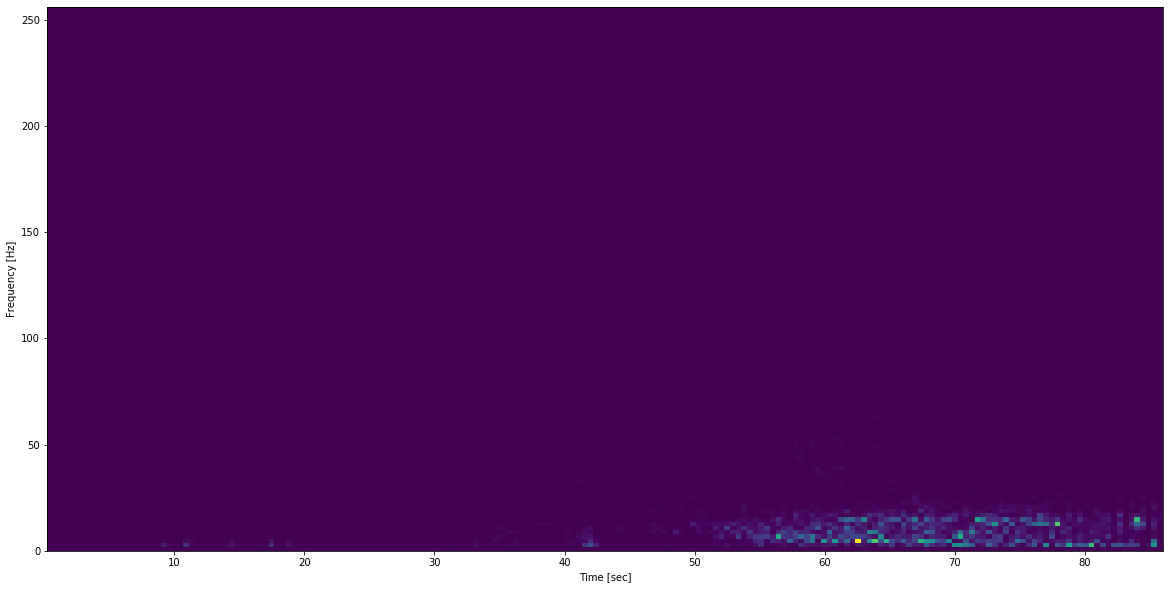

In [26]:
plot_spectrogram(seizure1_signal, start, end)

## After seizure

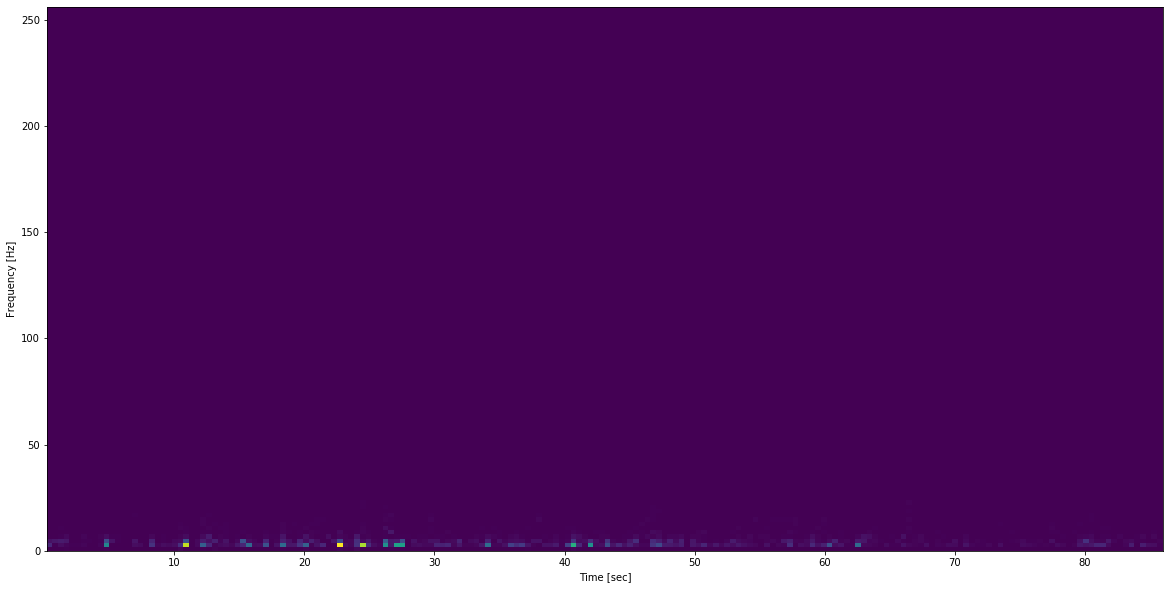

In [27]:
plot_spectrogram(normal1_signal, start, end)